In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib as mpl
import math
import pickle
import matplotlib.patches as mpatches
from tqdm import tqdm
from scipy import stats


dat_path = os.getcwd()[:-4] + 'data/'
figures_path = os.getcwd()[:-4] + 'figures/'
prelim_fig_path = os.getcwd()[:-4] + 'figures/preliminary/'
generated_dat_path = os.getcwd()[:-4] + 'data/generated_data/'

text_font = 30

In [2]:
norm_quant = 'Runs'
odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

odi_final.columns

Index(['search_ID', 'Match_ID', 'Match_Date', 'Venue', 'Team', 'Overs', 'Runs',
       'Wickets', 'player_name', 'bat_pos', 'bat_run', 'bat_balls',
       'bat_fours', 'bat_sixes', 'bat_wicket', 'bowl_overs', 'bowl_maiden',
       'bowl_runs', 'bowl_wickets', 'captain', 'wicketkeeper', 'PoM', 'Winner',
       'Batting_Order', 'renormalized_bat_run', 'renormalized_runs',
       'renormalized_bowl_runs', 'team_match_num', 'batsmen', 'bowler',
       'allrounder', 'opp_wickets'],
      dtype='object')

In [3]:
def axis_decor(ax, text_font, major_length, minor_length, linewidth):

    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)

    ax.tick_params(axis='both', which='major', labelsize=text_font, length=major_length, width=linewidth)
    ax.tick_params(axis='both', which='minor', labelsize=text_font, length=minor_length, width=linewidth)

In [4]:
def compute_best_perform(player_data_array, num_best, scale):
    
    best_performances = []
    original_indices = np.arange(len(player_data_array[:,0]))

    while len(best_performances) < num_best:
        
        # check if there are non-nan values
        if np.sum(np.isnan(player_data_array[:,0])) == len(player_data_array[:,0]):
            best_row = num_best - len(player_data_array[:,0])

        else:
            # Identifying the maximum number of runs scored or maximum wickets taken
            max_perform = np.nanmax(player_data_array[:,0])

            # Filtering the rows where the player scored the maximum runs or took the maximum wickets
            max_perform_inds = np.where(player_data_array[:, 0] == max_perform)[0]

            # If multiple instances, choose the one with the lowest 'bat_balls' (for runs) or 'bowl_runs' (for wickets)
            if len(max_perform_inds) > 1:
                best_row = max_perform_inds[np.argmin(player_data_array[max_perform_inds, 1])]
            else:
                try:
                    best_row = max_perform_inds[0]
                except:
                    best_row = max_perform_inds

        # Append the original index of the best performance
        if scale == 'absolute':
            best_performances.append(original_indices[best_row])
        elif scale == 'relative':
            best_performances.append(original_indices[best_row]/len(player_data_array[:,0]))

        # Remove the row with the best performance
        player_data_array = np.delete(player_data_array, best_row, axis=0)
        original_indices = np.delete(original_indices, best_row)

    return best_performances

In [5]:
def best_perform_data(min_career, norm_quant, category, rand_num, scale):

    odi_final = pd.read_csv(dat_path + f'ODI_data_cleaned_merged_renorm_{norm_quant}_with_team_match_num_with_player_designation.csv')

    odi_final['Match_Date'] = pd.to_datetime(odi_final['Match_Date'])

    players_list = np.unique(odi_final['player_name'].astype(str))

    data = np.zeros((len(players_list), 3))
    randomized = np.zeros((len(players_list), 3, rand_num))

    for p, player in tqdm(enumerate(players_list)):
        temp_df = odi_final[odi_final['player_name'] == player]
        temp_df = temp_df.sort_values(by='Match_Date')
        temp_df = temp_df.reset_index(drop=True)

        if category == 'bat':
            if temp_df['batsmen'].sum() > min_career:
                dat_array = temp_df[['renormalized_bat_run', 'bat_balls']].values
            else:
                continue
                    
        elif category == 'bowl':
            if temp_df['bowler'].sum() > min_career:
                dat_array = temp_df[['bowl_wickets', 'bowl_runs']].values
            else:
                continue
        
        data[p, :] = compute_best_perform(dat_array, 3, scale=scale)
        
        for r in range(rand_num):
            rnd_array = np.random.permutation(dat_array)
            randomized[p, :, r] = compute_best_perform(rnd_array, 3, scale=scale)


    with open(generated_dat_path + f'best_perform_data_{scale}_min_career_{min_career}_renorm_{norm_quant}_for_{category}_rnd_num_{rand_num}.pkl', 'wb') as f:
        pickle.dump([data, randomized], f)



''''''''''''''''''''''''
# best_perform_data(min_career=25, norm_quant='Runs', category='bat' , rand_num=100, scale='absolute')
# best_perform_data(min_career=25, norm_quant='Runs', category='bowl', rand_num=100, scale='absolute')

# best_perform_data(min_career=25, norm_quant='Runs', category='bat' , rand_num=100, scale='relative')
# best_perform_data(min_career=25, norm_quant='Runs', category='bowl', rand_num=100, scale='relative')

''

KstestResult(statistic=0.03439926062846582, pvalue=0.15488964263464644, statistic_location=23.0, statistic_sign=1)


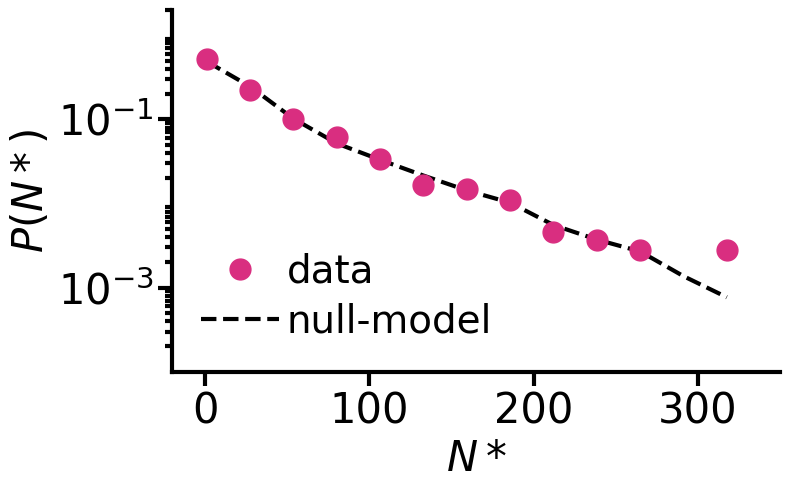

KstestResult(statistic=0.04049907578558232, pvalue=0.05797784779786708, statistic_location=0.6086956521739131, statistic_sign=1)


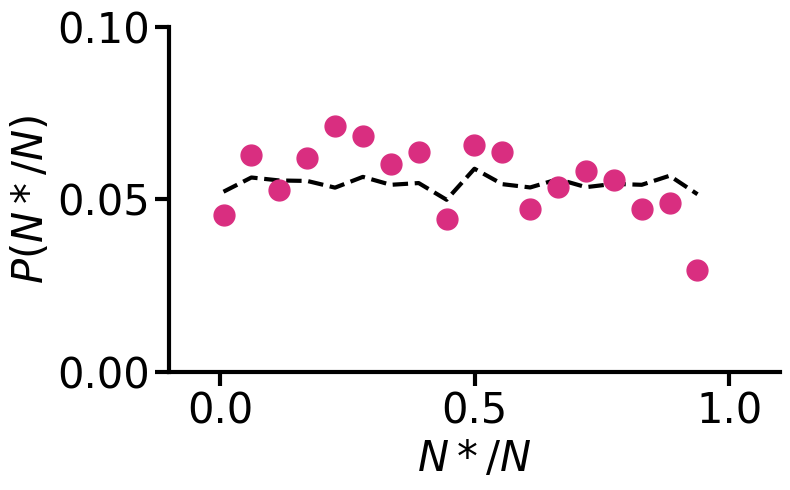

In [6]:
def best_perform_plot(min_career, norm_quant, rand_num, nbins, scale):

    category_list = ['bat', 'bowl']
    color_list = ['#398676','#E96659','#DE9E37']

    fig, ax = plt.subplots(1,1,figsize=(8, 5))

    _dat, _rnd = [], []

    for category in category_list:

        with open(generated_dat_path + f'best_perform_data_{scale}_min_career_{min_career}_renorm_{norm_quant}_for_{category}_rnd_num_{rand_num}.pkl', 'rb') as f:
            data, randomized = pickle.load(f)

        true_dat_ind = np.where(data[:,0] != 0)[0]

        data = data[true_dat_ind]
        randomized = randomized[true_dat_ind]


        _dat.append(data[:,0])
        for i in range(rand_num):
            _rnd.append(randomized[:,0, i])

    _dat = [item for sublist in _dat for item in sublist]
    _rnd = [item for sublist in _rnd for item in sublist]

    ''' statistical test '''
    print(stats.ks_2samp(_dat, _rnd))
        
    counts, bins = np.histogram(_dat, bins=nbins, density=False)    
    counts_rnd, _ = np.histogram(_rnd, bins=bins, density=False)
    
    ax.plot(bins[:-1], counts/len(_dat), linestyle=None, linewidth=0, color= '#d92e80', marker='o', markersize=15, label=f'data', zorder=100)
    ax.plot(bins[:-1], counts_rnd/len(_rnd), color='black', linewidth=3, linestyle='--', label='null-model')

    

    if scale == 'absolute':
        ax.set_yscale('log')

        ax.set_xlabel(r'$N*$', fontsize=text_font)
        ax.set_ylabel(r'$P(N*)$', fontsize=text_font)

        ax.set_xlim(-20,350)
        ax.set_ylim(1e-4, 2)
        ax.set_yticks([1e-3, 1e-1])
        
        ax.legend(fontsize=text_font-2, loc='lower left', frameon=False, bbox_to_anchor=(-0.01, -0.01, 0.2, 0.2), labelspacing=0.3, handletextpad=0.2, columnspacing=0.1)
        
    elif scale == 'relative':

        ax.set_xlabel(r'$N*/N$', fontsize=text_font)
        ax.set_ylabel(r'$P(N*/N)$', fontsize=text_font)

        ax.set_xlim(-0.1,1.1)
        ax.set_ylim(0, 0.1)
        ax.set_yticks([0, 0.05, 0.1])



    axis_decor(ax, text_font, 10, 5, 3)
    
    

    plt.tight_layout()
    plt.savefig(prelim_fig_path + f'{scale}_best_perform_min_career_{min_career}_renorm_{norm_quant}_rnd_num_{rand_num}.png', format='png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
        
best_perform_plot(min_career=25, norm_quant='Runs', rand_num=100, nbins=13, scale='absolute')
best_perform_plot(min_career=25, norm_quant='Runs', rand_num=100, nbins=18, scale='relative')

In [7]:
def hot_streak_computation(dat, indices, nbins):

    bin_boundaries = np.linspace(0, 1, nbins+1)

    abs_diff = np.abs(dat[:, indices[0]] - dat[:, indices[1]])

    binning_process = np.digitize(abs_diff, bin_boundaries)

    frequency = np.unique(binning_process, return_counts=True)[1]

    frequency[nbins-1] = np.sum(frequency[nbins-1:])

    return frequency[:nbins]

3.862847617862432e-18
0.17076176482553207
6.576800465435483e-18
4.199355670704378e-18
3.768682723209751e-18
5.643355871048841e-18
6.910569482767166e-06
0.0618318192471454
4.079864716625467e-18
5.567792186467541e-18


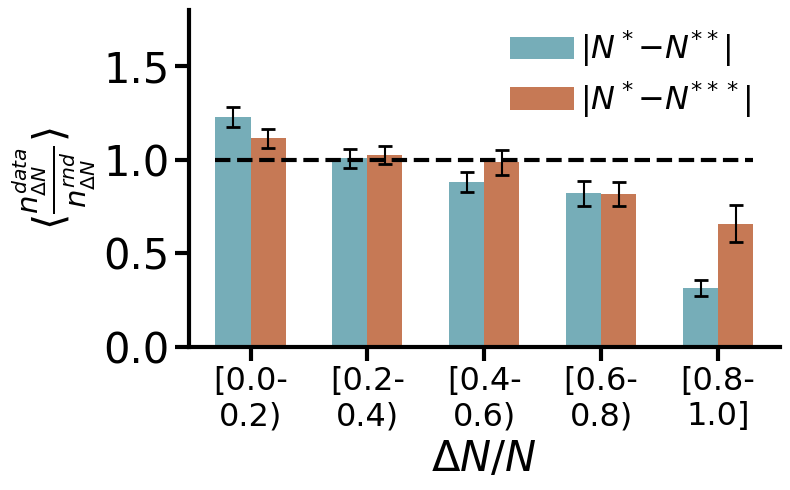

In [14]:
def hot_streak_plot(min_career, norm_quant, rand_num, nbins, scale='relative'):

    category_list = ['bat', 'bowl']

    color_list = ['#5499A6','#B8572B']

    bin_boundaries = np.linspace(0, 1, nbins+1)

    fig, ax = plt.subplots(1,1,figsize=(8, 5))

    _first_second, _first_third = np.zeros(nbins), np.zeros(nbins)

    _first_second_rnd, _first_third_rnd = np.zeros((nbins, rand_num)), np.zeros((nbins, rand_num))

    for category in category_list:

        with open(generated_dat_path + f'best_perform_data_{scale}_min_career_{min_career}_renorm_{norm_quant}_for_{category}_rnd_num_{rand_num}.pkl', 'rb') as f:
            data, randomized = pickle.load(f)

        true_dat_ind = np.where(data[:,0] != 0)[0]

        data = data[true_dat_ind]
        randomized = randomized[true_dat_ind]

        _first_second += hot_streak_computation(data, [0, 1], nbins)
        _first_third += hot_streak_computation(data, [0, 2], nbins)

        for r in range(rand_num):
            _first_second_rnd[:, r] += hot_streak_computation(randomized[:, :, r], [0, 1], nbins)
            _first_third_rnd[:, r] += hot_streak_computation(randomized[:, :, r], [0, 2], nbins)


    final_first_second_dat = _first_second[:, np.newaxis]/_first_second_rnd
    final_first_third_dat = _first_third[:, np.newaxis]/_first_third_rnd


    for i in range(nbins):
        print(stats.wilcoxon(final_first_second_dat[i],[1]*rand_num).pvalue)
    for i in range(nbins):
        print(stats.wilcoxon(final_first_third_dat[i],[1]*rand_num).pvalue)



    x_shift = 0.15
    width = 0.3
    x_ticks = np.arange(1, nbins+1)
    
    ax.bar(x_ticks-x_shift, height=np.mean(final_first_second_dat, axis=1),width=width, color=color_list[0], alpha=0.8,
           label=f'|$N^*$'+'$-$'+f'$N^{{**}}$|')
    ax.errorbar(x_ticks-x_shift, np.mean(final_first_second_dat, axis=1), yerr=np.std(final_first_second_dat, axis=1), fmt='none', capsize=5, capthick=2, color='black')
    
    
    ax.bar(x_ticks+x_shift, height=np.mean(final_first_third_dat, axis=1), width=width, color=color_list[1], alpha=0.8, 
           label=f'|$N^*$'+'$-$'+f'$N^{{***}}$|')
    ax.errorbar(x_ticks+x_shift, np.mean(final_first_third_dat, axis=1), yerr=np.std(final_first_third_dat, axis=1), fmt='none', capsize=5, capthick=2, color='black')
    


    ax.hlines(1, 1-width, nbins+width, color='black', linestyle='--', linewidth=3)

    ax.set_xlabel(r'$ \Delta N/N$', fontsize=text_font)
    ax.set_ylabel(r'$\langle \frac{n_{\Delta N}^{data}}{n_{\Delta N}^{rnd}} \rangle$', fontsize=text_font)
    axis_decor(ax, text_font, 10, 5, 3)

    ax.set_ylim(0.0, 1.8)
    xLabels = [f'[{bin_boundaries[i]:.1f}-\n{bin_boundaries[i+1]:.1f})' for i in range(nbins)]
    xLabels[-1] = f'[{bin_boundaries[-2]:.1f}-\n{bin_boundaries[-1]:.1f}]'

    ax.set_xticks(x_ticks, xLabels,  fontsize=text_font-7)
    

    ax.legend(fontsize=text_font-7, loc='upper right', frameon=False, bbox_to_anchor=(0.8, 0.83, 0.2, 0.2), labelspacing=0.3, handletextpad=0.2, ncol=1)
    # ax.set_title(f'nbins {nbins}', fontsize=text_font)

    plt.tight_layout()
    plt.savefig(prelim_fig_path + f'hot_streak_min_career_{min_career}_renorm_{norm_quant}_rnd_num_{rand_num}.png', format='png', dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


hot_streak_plot(min_career=25, norm_quant='Runs', rand_num=100, nbins=5, scale='relative')